# mOWL Tutorial

This tutorial will teach you how to use machine learning with ontologies. The tutorial captures the different approaches for generating OWL ontology embeddings, and methods to use them. We rely on the mOWL library which intends to implement all embedding methods for Semantic Web (OWL) ontologies.

The majority of libraries for processing OWL ontologies are written in Java while most machine learning libraries are written in Python. First, we will need to access Java libraries in Python so that we can process ontologies and perform reasoning. We rely on the JPype library for this purpose which makes Java classes available in Python. We also have to set the memory available to the Java Virtual Machine.

In [1]:
import mowl
mowl.init_jvm("40g") # the amount of memory to assign to the JVM


We can now access classes from the OWLAPI (the main reference implementation for processing Semantic Web ontologies) through their Python interfaces, just as we would in Java. The next code will load an ontology and classify it using the Elk reasoner. We then query for all subclasses of the Human Phenotype Ontology (HPO) class "Mode of inheritance".

In [ ]:
from org.semanticweb.elk.owlapi import ElkReasonerFactory
from org.semanticweb.owlapi.apibinding import OWLManager
from org.semanticweb.owlapi.model import IRI

manager = OWLManager.createOWLOntologyManager()
fac = manager.getOWLDataFactory()
ont = manager.loadOntologyFromOntologyDocument(IRI.create("file:merged-phenomenet.owl"))
print("Number of classes: ", ont.getClassesInSignature(True).size())

reasoner_factory = ElkReasonerFactory()
reasoner = reasoner_factory.createReasoner(ont)

for i in reasoner.getSubClasses(fac.getOWLClass(IRI.create("http://purl.obolibrary.org/obo/HP_0000005")), False).getFlattened():
    print(i)
    

mOWL wraps some functionality that is commonly used for generating ontology embeddings in the MOWLReasoner class, which can be used to compute a limited form of the deductive closure of an ontology.

# Embedding ontologies

mOWL implements several different ontology embeddings. The overall recipe of embedding ontologies is:
* generate a Dataset for the ontology
* project the OWL ontology suitable for an embedding
* apply the embedding model
* infer axioms using an inference model
* (optional) evaluate the embeddings using an evaluation set

## Datasets

mOWL operates on OWL axioms, and every dataset consists of a set of OWL axioms (here, also called an ontology). mOWL also provides several datasets for testing purposes, and we will use a small dataset here first, the PPI Yeast Slim Dataset.

PPIYeastSlimDataset consists of axioms from the Gene Ontology (GO), in particular the "yeast slim" of the GO, a set of yeast proteins, and an association between proteins and GO classes. The GO is natively available in OWL, but the associations are commonly available only as "annotation" file from various websites. This dataset makes a particular ontological commitment and represents all proteins as OWL classes. Given a protein $P$ and GO class $G$ that is an annotation of $P$, the following axiom is in the PPIYeastSlimDataset: $P \sqsubseteq \exists hasFunction.G$. PPIYeastSlimDataset further adds protein--protein interactions to the ontology; if protein $P_1$ interacts with $P_2$, the axioms $P_1 \sqsubseteq \exists interactsWith.P2$ and $P_2 \sqsubseteq \exists interactsWith.P_1$ are added.

We can print the axioms in the ontology underlying `PPIYeastSlimDataset`:

In [ ]:
from mowl.datasets.ppi_yeast import PPIYeastSlimDataset, PPIYeastDataset

dataset = PPIYeastSlimDataset()
for i in dataset.ontology.getAxioms(True):
    print(i)


A Dataset may additionally have validation and testing data. Both validation and testing are again sets of axioms (ontologies). For the `PPIYeastSlimDataset`, both validation and testing is done only on interactions. We can investigate the axioms used for testing:

In [ ]:
for i in dataset.testing.getAxioms(True):
    print(i)
print(dataset.testing.getAxioms(True).size())

## Graph generation

projection operation from axioms into graphs...

In [17]:
####### WARNING #######
#from org.mowl.Projectors import DL2VecProjector
#projector = DL2VecProjector( True)

#using the lines above calls the JAVA method. However, we have Python wrappers that can be used in two ways: 

from mowl.projection.dl2vec.model import DL2VecProjector
projector = DL2VecProjector(bidirectional_taxonomy = True)
# or
from mowl.projection.factory import projector_factory
projector = projector_factory("dl2vec", bidirectional_taxonomy = True)


edges = projector.project(dataset.ontology)

# The edges now are python structures.


INFO: Number of ontology classes: 11027


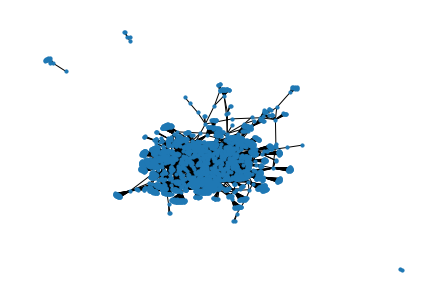

In [4]:
import networkx as nx
import pylab as plt

elist = []
count = 5000
for i in edges:
    if count > 0:
        elist.append( (i.src(), i.dst()) )
    count -= 1
    
G=nx.from_edgelist(elist)
nx.draw(G, node_size=10)
plt.show()

Now that we generated a graph from the OWL axioms, we can embed the graph using any (heterogeneous) graph embedding method. The reason we need a method to embed "heterogeneous" graphs is that the projection operations we use consider the relation types, and they should be treated differently in the embedding. Fortunately, there are *many* methods to generate [Knowledge Graph Embeddings](https://persagen.com/files/misc/Wang2017Knowledge.pdf) and mOWL provides access to most of them either by directly implementing them or through the [PyKEEN library](https://github.com/pykeen/pykeen).

Let's start by using embeddings based on random walks over the graph followed by Word2Vec. This method applies a repeated random walk starting from each node to generate a "corpus", followed by a word embedding that captures co-occurrence relations in this corpus. We have to set some parameters: the number of walks from each node; the length/depth of the random walk; a restart probability; and a file to write these walks to:

In [ ]:
from mowl.walking.node2vec.model import Node2Vec
walker = Node2Vec(
	              100, # number of walks
				  10, # length of each walk
				  p = 10,
                  q = 0.1,
				  workers = 8, # number of usable CPUs
                  outfile = '/tmp/a.out'
				  )

walks = walker.walk(edges)


In [ ]:
from mowl.walking.deepwalk.model import DeepWalk
walker = DeepWalk(
	              100, # number of walks
				  10, # length of each walk
				  0, # probability of restart
				  workers = 8, # number of usable CPUs
                  outfile = '/tmp/a.out'
				  )

walks = walker.walk(edges)


We can now embed the corpus using a language model like Word2Vec. Word2Vec captures co-occurrence relations within a window. We just use a standard Word2Vec implementation here. Parameters we have to set is the embedding method (Skipgrap or Continuout Bag Of Words), the minimum occurrence count of a word (should be set to `1` as otherwise some embeddings may be missing), the embedding size, the window size (within which co-occurrence is evaluated), and the epochs.

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence


corpus = LineSentence("/tmp/a.out")

w2v_model = Word2Vec(
       corpus,
       sg=1,
       min_count=1,
       vector_size=3,
       window = 10,
       epochs = 5,
       workers = 16)

vectors = w2v_model.wv


The result of the embedding is a set of vectors representing each word in the corpus, and therefore one vector for each entity that was included in the graph generated from the ontology axioms. We can visualize these embeddings using a TNSE.

INFO: Number of ontology classes: 56750
1148


INFO:root:Found 49934 embedding vectors. Processing only 1148.
/home/zhapacfp/anaconda3/envs/aibio/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/aibio/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1148 samples in 0.000s...
[t-SNE] Computed neighbors for 1148 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1148
[t-SNE] Computed conditional probabilities for sample 1148 / 1148
[t-SNE] Mean sigma: 0.098703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.234734
[t-SNE] KL divergence after 5000 iterations: 0.366096


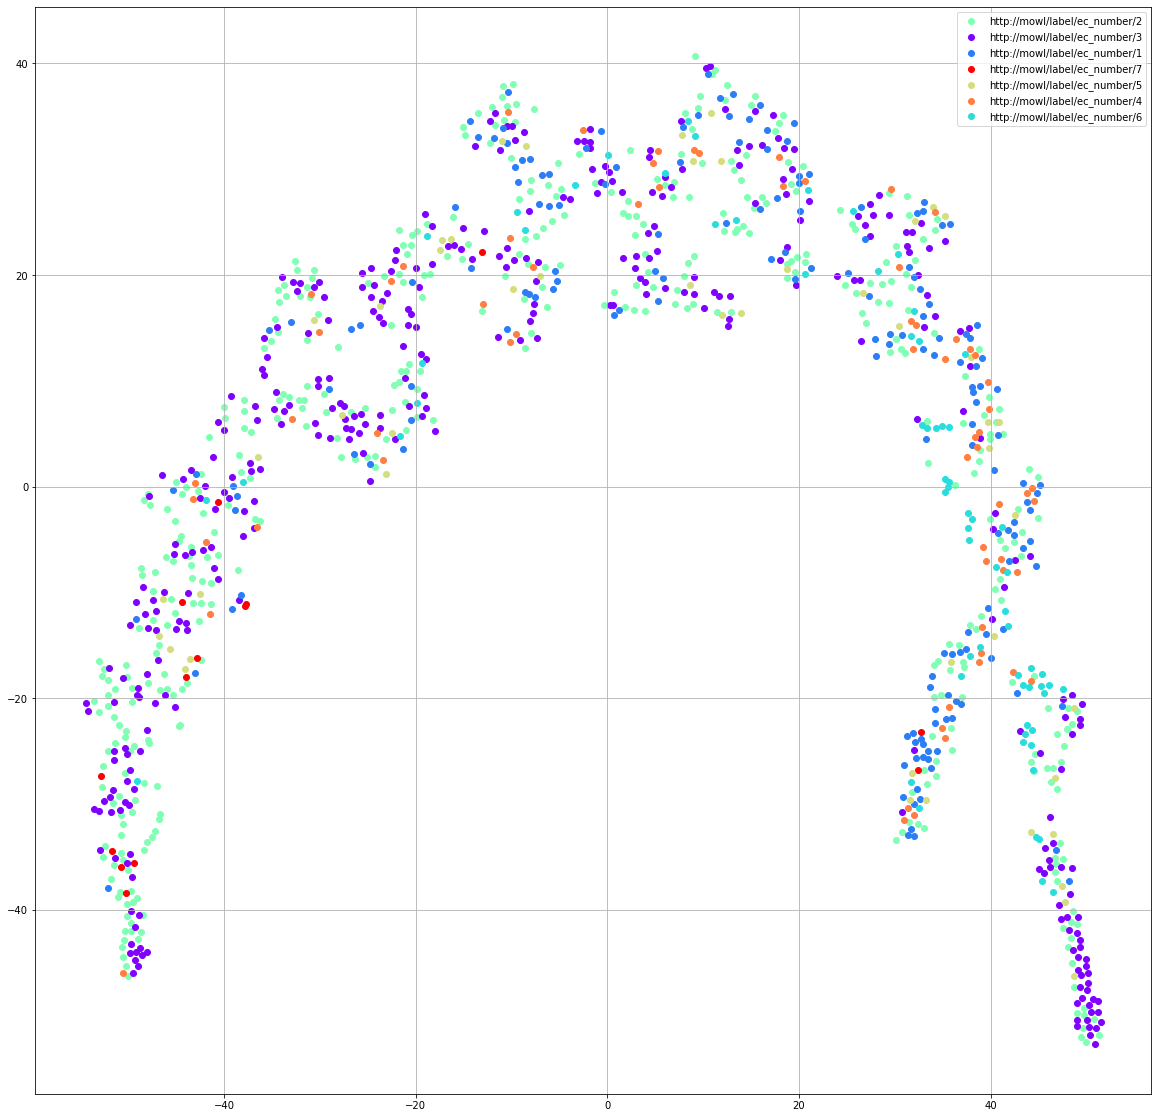

In [12]:
#from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt




#labels = [i for i in w2v_model.wv.key_to_index]
#tokens = w2v_model[labels]

############ FERNANDO EDITS ###########
# The mowl tsne is a wrapper for the sklearn.manifold tsne.
from mowl.visualization.base import TSNE
labels = dataset.get_labels() #PPIYeast or PPIYeastSlim datasets now contain the ec number labels. The labels are a dicttionary of the form entity_name -> label_name
print(len(labels))
tsne = TSNE(vectors, labels)
tsne.generate_points(5000, workers = 16, verbose = 1)
tsne.show()

#TSNE plot can be saved using the following line.
#tsne.savefig(path_to_image.jpg)




As we can see, the embeddings (somehow) cluster according to their Enzyme Classification. We may then use a similarity function between the embedding vectors to generate "meaningful" relations. In mOWL, meaningful relations between OWL entities are expressed in the form of OWL axioms. To obtain axioms from the embeddings, we need an inference method that uses similarity to determine axioms. Here, we rely on cosine similarity between (proteins) $X$ and $Y$ in order to predict axioms of the form $X \sqsubseteq \exists interactsWith.Y$.

Random walks are a form of embedding of graphs that relies on adjacency. However, other knowledge graph embeddings are more explicit about the kind of graph properties they preserve. For example, [TransE](https://paperswithcode.com/method/transe) generates embeddings $e$ for nodes and edge types such that $e(h) + e(r) \approx e(t)$ if $r(h,t)$ is an edge in the graph. But there are hundreds of similar embedding methods available, and we rely on the PyKEEN library for accessing these kinds of embeddings. Here is an example of using TransE to generate an embedding of the projected graph:

In [ ]:
from mowl.embeddings.translational.model import TranslationalOnt
import torch
cuda0 = torch.device('cuda:0')

trans_model = TranslationalOnt(
     edges,
     trans_method = "transE",
     embedding_dim = 50,
     epochs = 20,
     batch_size = 32
 )

trans_model.train()
embeddings = trans_model.get_embeddings()

## Embeddings without graph projection

So far, we have just reused knowledge graph embedding methods, and first projected ontologies onto graphs. This works great, in particular as there are so many knowledge graph embedding methods available. However, there are some disadvantages; in particular, projecting axioms onto graphs will almost always lose some information. For example, almost no graph projection method will adequately deal with disjointness between classes, or they may not consider axioms of a certain complexity. mOWL implements a number of embedding methods that are based directly on axioms. We can try one of the simplest methods, Onto2Vec, which simply applies a language model to the ontology axioms directly. We first extract the axioms as a "corpus" (set of sentences), and then we embed this using Word2Vec:

In [ ]:
from mowl.corpus.base import extract_axiom_corpus, extract_annotation_corpus

extract_axiom_corpus(dataset.ontology, "/tmp/corpus")
extract_annotation_corpus(dataset.ontology, "/tmp/corpus")

sentences = LineSentence("/tmp/corpus")

model = Word2Vec(
         sentences,
         sg = 1,
         min_count = 1,
         vector_size = 20,
         window = 5,
         epochs = 20,
         workers = 8
     )

vectors = model.wv


As before we can now visualize the embeddings generated:

In [ ]:
from mowl.embeddings.elembeddings.model import ELEmbeddings
import torch

cuda0 = torch.device('cuda:0')

model = ELEmbeddings(
     dataset,
     epochs = 1000,
     margin = 0.1,
     model_filepath = "model.th",
 )

model.train()


In [ ]:
dataset.get_evaluation_classes()